In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report)
import transformers
import accelerate
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import warnings

c:\Users\Vlad_PC_2022\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('../data/raw/low_complexity.csv')

In [5]:
df

,text,label
0,Tesla stock surges again,2
1,Inflation fears rattle markets,0
2,Apple reports record profits,2
3,Interest rates stay steady,1
4,Amazon shares drop sharply,0
...,...,...
1047,Interest rates are rising,0
1048,The stock market is unpredictable,1
1049,Apple new product launch was successful,2
1050,The economy is recovering slowly,1


# Предобработка

In [6]:
# Проверка на дубликаты
duplicates = df.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")

Количество дубликатов: 140


In [7]:
# Удаление дубликатов
df = df.drop_duplicates()

In [8]:
# Проверка на пустые строки
missing_values = df.isnull().sum()
print(f"Пустые строки в каждом столбце:\n{missing_values}")

Пустые строки в каждом столбце:
text     0
label    0
dtype: int64


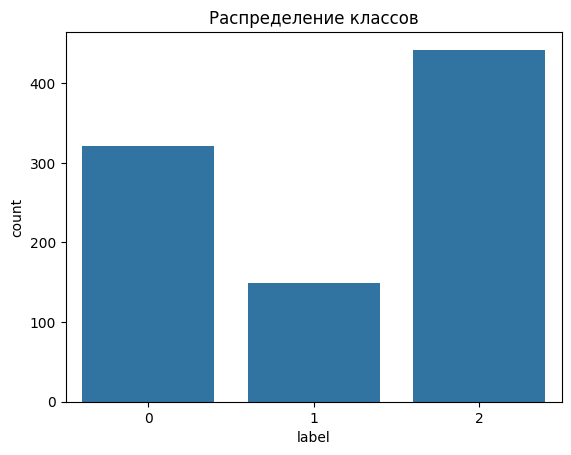

In [9]:
# Визуализация распределения классов
sns.countplot(x='label', data=df)
plt.title('Распределение классов')
plt.show()

In [10]:
# Балансировка датасета
class_counts = df['label'].value_counts()
print("Количество экземпляров в каждом классе:\n", class_counts)

Количество экземпляров в каждом классе:
 label
2    442
0    321
1    149
Name: count, dtype: int64


In [11]:
# Балансировка классов (пример: через повторение меньшинства)
min_class = class_counts.idxmin()
max_class = class_counts.idxmax()
difference = class_counts[max_class] - class_counts[min_class]

In [12]:
# Повторяем записи в меньшинственном классе
min_class_samples = df[df['label'] == min_class].sample(difference, replace=True)
df = pd.concat([df, min_class_samples])

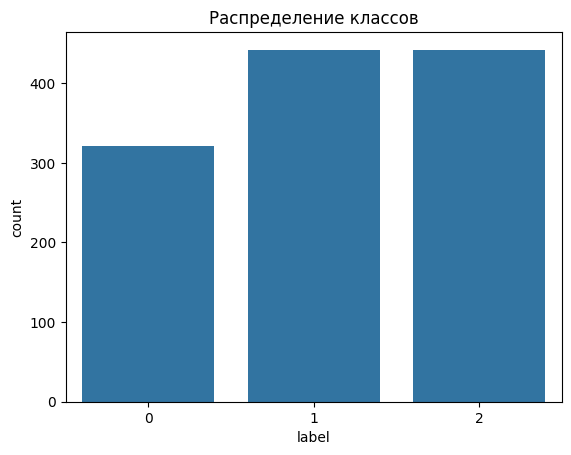

In [13]:
# Визуализация распределения классов
sns.countplot(x='label', data=df)
plt.title('Распределение классов')
plt.show()

In [14]:
X = df['text']
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки:', X_train.shape[0])
print('Размер валидационной выборки:', X_val.shape[0])

Размер тренировочной выборки: 964
Размер валидационной выборки: 241


# Обучим Бертушку

In [15]:
X_train = [str(x) for x in X_train]

print(type(X_train))
print(X_train)

<class 'list'>
['Microsoft sees strong demand for cloud services', 'Google revenue missed estimates', 'Tesla releases impressive autopilot technology', 'Consumer confidence hits all-time high', 'Starbucks sales missed projections', 'Google introduces new advertising options', 'Disney streaming service surpasses subscriber targets', 'GameStop stock price plummets', 'American Express introduces new card', 'Home prices continue to rise', 'Bond yields hit historic lows', 'Stock prices fluctuate unpredictably', 'Central bank maintains policies', 'Amazon expands into healthcare industry', 'Google stock price rose', 'The Federal Reserve kept rates steady', 'Intel faces supply chain disruptions', 'Amazon announces new warehouse locations', 'Central bank maintains policies', 'Investor confidence remains high', 'Tesla stock falls after recall announcement', 'Netflix introduces new pricing plans', 'Google faces antitrust scrutiny', 'McDonald introduces new menu items', 'Inflation concerns drive u

In [16]:
# Загружаем токенайзер для BERT'a
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Токенизируем входящий текст
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

In [17]:
# Создадим датасет
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key:torch.tensor(val[idx], dtype=torch.long)
                for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

In [18]:
# Создадим датасеты для тренировки, валидации и тестирования выборок
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
val_dataset = SentimentDataset(val_encodings, y_val.tolist())

In [19]:
# Загружаем BERT для классификации
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Определяем аргументы
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [21]:
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [22]:
trainer_bert.train()

  0%|          | 0/363 [00:00<?, ?it/s]C:\Users\Vlad_PC_2022\AppData\Local\Temp\ipykernel_14700\3716857575.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx], dtype=torch.long)
  3%|▎         | 10/363 [00:05<03:14,  1.82it/s]

{'loss': 1.0975, 'grad_norm': 6.145534992218018, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.08}


  6%|▌         | 20/363 [00:11<03:04,  1.86it/s]

{'loss': 1.0846, 'grad_norm': 5.143656253814697, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.17}


  8%|▊         | 30/363 [00:16<03:07,  1.77it/s]

{'loss': 1.119, 'grad_norm': 13.750029563903809, 'learning_rate': 3e-06, 'epoch': 0.25}


 11%|█         | 40/363 [00:22<03:01,  1.78it/s]

{'loss': 1.0908, 'grad_norm': 6.14765739440918, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.33}


 14%|█▍        | 50/363 [00:27<02:54,  1.79it/s]

{'loss': 1.0547, 'grad_norm': 6.9486799240112305, 'learning_rate': 5e-06, 'epoch': 0.41}


 17%|█▋        | 60/363 [00:33<02:41,  1.87it/s]

{'loss': 1.1124, 'grad_norm': 6.184359073638916, 'learning_rate': 6e-06, 'epoch': 0.5}


 19%|█▉        | 70/363 [00:38<02:34,  1.89it/s]

{'loss': 1.0422, 'grad_norm': 9.145195007324219, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.58}


 22%|██▏       | 80/363 [00:44<02:38,  1.78it/s]

{'loss': 1.02, 'grad_norm': 9.223701477050781, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.66}


 25%|██▍       | 90/363 [00:49<02:35,  1.76it/s]

{'loss': 1.0345, 'grad_norm': 9.63981819152832, 'learning_rate': 9e-06, 'epoch': 0.74}


 28%|██▊       | 100/363 [00:54<02:15,  1.94it/s]

{'loss': 0.9753, 'grad_norm': 7.759426116943359, 'learning_rate': 1e-05, 'epoch': 0.83}


 30%|███       | 110/363 [01:00<02:11,  1.93it/s]

{'loss': 0.9837, 'grad_norm': 11.907332420349121, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.91}


 33%|███▎      | 120/363 [01:05<02:18,  1.76it/s]

{'loss': 0.9681, 'grad_norm': 7.428607940673828, 'learning_rate': 1.2e-05, 'epoch': 0.99}


 36%|███▌      | 130/363 [01:11<02:14,  1.73it/s]

{'loss': 0.932, 'grad_norm': 10.33288288116455, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.07}


 39%|███▊      | 140/363 [01:16<02:06,  1.77it/s]

{'loss': 0.8549, 'grad_norm': 11.20372486114502, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.16}


 41%|████▏     | 150/363 [01:22<02:00,  1.77it/s]

{'loss': 0.7994, 'grad_norm': 9.025761604309082, 'learning_rate': 1.5e-05, 'epoch': 1.24}


 44%|████▍     | 160/363 [01:28<01:57,  1.73it/s]

{'loss': 0.8696, 'grad_norm': 9.423662185668945, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.32}


 47%|████▋     | 170/363 [01:33<01:50,  1.75it/s]

{'loss': 0.7604, 'grad_norm': 16.464067459106445, 'learning_rate': 1.7000000000000003e-05, 'epoch': 1.4}


 50%|████▉     | 180/363 [01:39<01:45,  1.73it/s]

{'loss': 0.5637, 'grad_norm': 15.518101692199707, 'learning_rate': 1.8e-05, 'epoch': 1.49}


 52%|█████▏    | 190/363 [01:45<01:36,  1.78it/s]

{'loss': 0.5887, 'grad_norm': 10.009645462036133, 'learning_rate': 1.9e-05, 'epoch': 1.57}


 55%|█████▌    | 200/363 [01:51<01:30,  1.81it/s]

{'loss': 0.4777, 'grad_norm': 12.671683311462402, 'learning_rate': 2e-05, 'epoch': 1.65}


 58%|█████▊    | 210/363 [01:56<01:26,  1.77it/s]

{'loss': 0.5166, 'grad_norm': 8.826823234558105, 'learning_rate': 2.1e-05, 'epoch': 1.74}


 61%|██████    | 220/363 [02:02<01:19,  1.79it/s]

{'loss': 0.5406, 'grad_norm': 15.755683898925781, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.82}


 63%|██████▎   | 230/363 [02:07<01:14,  1.80it/s]

{'loss': 0.6962, 'grad_norm': 23.660381317138672, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.9}


 66%|██████▌   | 240/363 [02:13<01:08,  1.79it/s]

{'loss': 0.5946, 'grad_norm': 11.262574195861816, 'learning_rate': 2.4e-05, 'epoch': 1.98}


 69%|██████▉   | 250/363 [02:18<01:02,  1.81it/s]

{'loss': 0.2882, 'grad_norm': 2.3718719482421875, 'learning_rate': 2.5e-05, 'epoch': 2.07}


 72%|███████▏  | 260/363 [02:24<00:58,  1.76it/s]

{'loss': 0.4219, 'grad_norm': 1.9727764129638672, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.15}


 74%|███████▍  | 270/363 [02:30<00:52,  1.77it/s]

{'loss': 0.7133, 'grad_norm': 17.241193771362305, 'learning_rate': 2.7000000000000002e-05, 'epoch': 2.23}


 77%|███████▋  | 280/363 [02:35<00:45,  1.81it/s]

{'loss': 0.3852, 'grad_norm': 14.203828811645508, 'learning_rate': 2.8000000000000003e-05, 'epoch': 2.31}


 80%|███████▉  | 290/363 [02:41<00:40,  1.80it/s]

{'loss': 0.3398, 'grad_norm': 17.747970581054688, 'learning_rate': 2.9e-05, 'epoch': 2.4}


 83%|████████▎ | 300/363 [02:46<00:32,  1.93it/s]

{'loss': 0.4247, 'grad_norm': 9.772485733032227, 'learning_rate': 3e-05, 'epoch': 2.48}


 85%|████████▌ | 310/363 [02:51<00:26,  1.97it/s]

{'loss': 0.4962, 'grad_norm': 8.832073211669922, 'learning_rate': 3.1e-05, 'epoch': 2.56}


 88%|████████▊ | 320/363 [02:57<00:24,  1.74it/s]

{'loss': 0.4121, 'grad_norm': 20.794570922851562, 'learning_rate': 3.2000000000000005e-05, 'epoch': 2.64}


 91%|█████████ | 330/363 [03:02<00:17,  1.85it/s]

{'loss': 0.4085, 'grad_norm': 2.1142168045043945, 'learning_rate': 3.3e-05, 'epoch': 2.73}


 94%|█████████▎| 340/363 [03:07<00:11,  2.01it/s]

{'loss': 0.4206, 'grad_norm': 29.27716636657715, 'learning_rate': 3.4000000000000007e-05, 'epoch': 2.81}


 96%|█████████▋| 350/363 [03:12<00:06,  2.05it/s]

{'loss': 0.5728, 'grad_norm': 19.770185470581055, 'learning_rate': 3.5e-05, 'epoch': 2.89}


 99%|█████████▉| 360/363 [03:17<00:01,  2.05it/s]

{'loss': 0.4462, 'grad_norm': 18.318340301513672, 'learning_rate': 3.6e-05, 'epoch': 2.98}


100%|██████████| 363/363 [03:19<00:00,  1.82it/s]

{'train_runtime': 199.9255, 'train_samples_per_second': 14.465, 'train_steps_per_second': 1.816, 'train_loss': 0.7210105742961579, 'epoch': 3.0}


TrainOutput(global_step=363, training_loss=0.7210105742961579, metrics={'train_runtime': 199.9255, 'train_samples_per_second': 14.465, 'train_steps_per_second': 1.816, 'total_flos': 20806515736272.0, 'train_loss': 0.7210105742961579, 'epoch': 3.0})

In [23]:
# Выведем метрики
val_predictions = trainer_bert.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)

print("Метрики на валидационном датасете:")
print("Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

C:\Users\Vlad_PC_2022\AppData\Local\Temp\ipykernel_14700\3716857575.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx], dtype=torch.long)
100%|██████████| 31/31 [00:01<00:00, 15.98it/s]

Метрики на валидационном датасете:
Accuracy: 0.8713692946058091
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        69
           1       0.84      0.89      0.86        93
           2       0.88      0.90      0.89        79

    accuracy                           0.87       241
   macro avg       0.88      0.87      0.87       241
weighted avg       0.87      0.87      0.87       241



C:\Users\Vlad_PC_2022\AppData\Local\Temp\ipykernel_14700\2778888779.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=precision, palette='Blues')
C:\Users\Vlad_PC_2022\AppData\Local\Temp\ipykernel_14700\2778888779.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=recall, palette='Greens')
C:\Users\Vlad_PC_2022\AppData\Local\Temp\ipykernel_14700\2778888779.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=f1_score, palette='Reds')


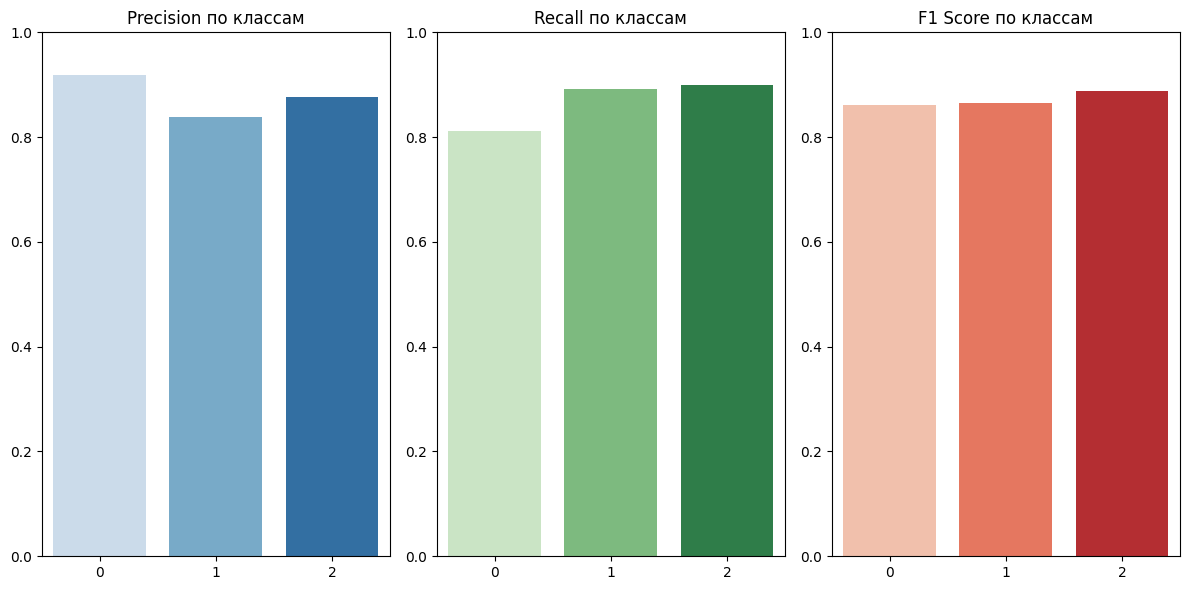

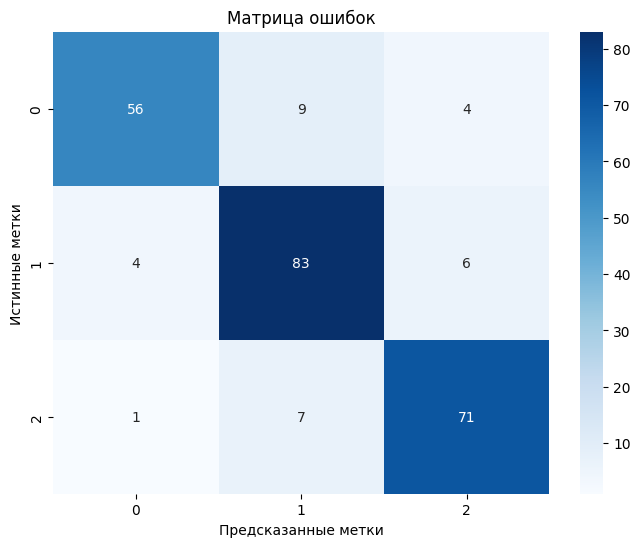

In [24]:
from sklearn.metrics import confusion_matrix

report = classification_report(y_val, val_preds, output_dict=True)

# Извлекаем метрики из отчета
labels = list(report.keys())[:-3]  # Исключаем 'accuracy', 'macro avg', 'weighted avg'
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Визуализация метрик
plt.figure(figsize=(12, 6))

# Создаем подграфики для Precision, Recall и F1 Score
x = np.arange(len(labels))  # метки классов

# Precision
plt.subplot(1, 3, 1)
sns.barplot(x=x, y=precision, palette='Blues')
plt.xticks(x, labels)
plt.title('Precision по классам')
plt.ylim(0, 1)

# Recall
plt.subplot(1, 3, 2)
sns.barplot(x=x, y=recall, palette='Greens')
plt.xticks(x, labels)
plt.title('Recall по классам')
plt.ylim(0, 1)

# F1 Score
plt.subplot(1, 3, 3)
sns.barplot(x=x, y=f1_score, palette='Reds')
plt.xticks(x, labels)
plt.title('F1 Score по классам')
plt.ylim(0, 1)

# Отображаем графики
plt.tight_layout()
plt.show()

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

# DisCoCat

In [25]:
BATCH_SIZE = 10
EPOCHS = 30
SEED = 2
LEARNING_RATE = 0.1

In [26]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [27]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('../data/proceed/cleaned_data_train2.txt')
test_labels, test_data = read_data('../data/proceed//cleaned_data_test2.txt')

In [28]:
train_data[2]

'Cryptocurrency market experiences volatility .'

# Парсим предложения

In [29]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


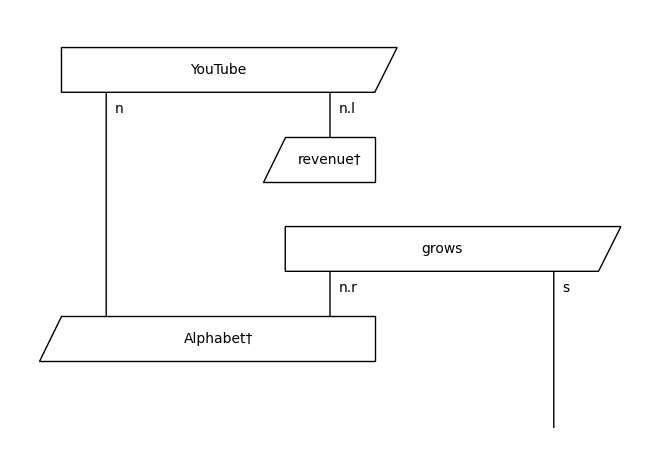

In [30]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

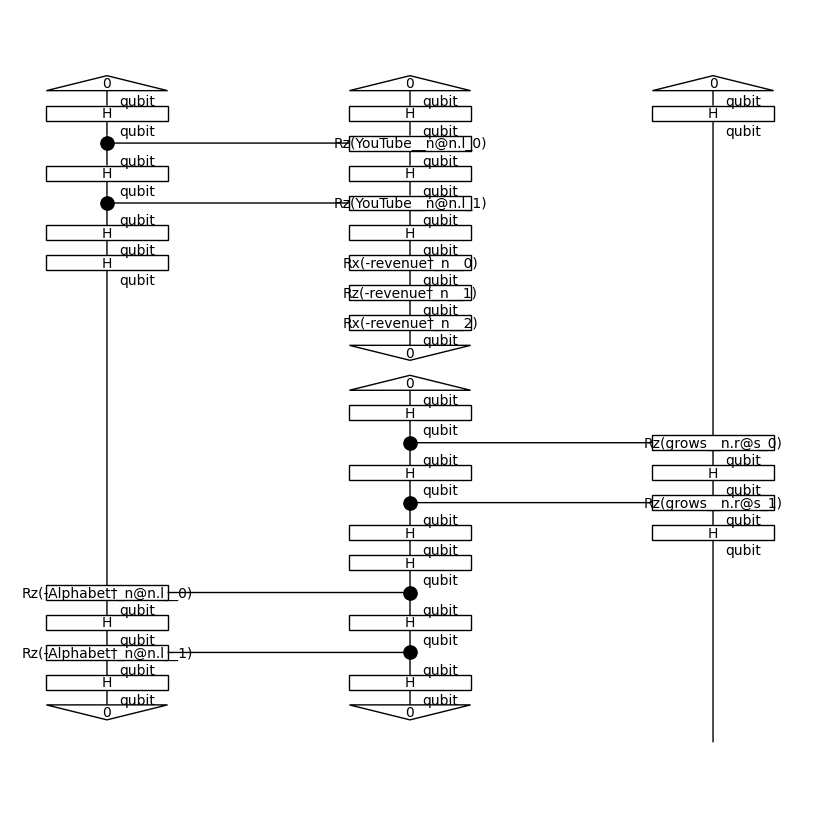

In [31]:
from lambeq import AtomicType, IQPAnsatz

# Определяем типы
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE

# Ковертируем строковые диаграммы в квантовые схемы
ansatz = IQPAnsatz({N: 1, S: 1, P: 1}, n_layers=2)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(8, 8))

In [32]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + test_circuits

model_discocat = PennyLaneModel.from_diagrams(all_circuits)
model_discocat.initialise_weights()

In [33]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(test_circuits, test_labels)

In [34]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == 
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [35]:
from lambeq import PytorchTrainer

trainer_discocat = PytorchTrainer(
        model=model_discocat,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions={"acc": acc},
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text',
        seed=SEED
    )

trainer_discocat.fit(train_dataset, val_dataset)

Epoch 1:   train/loss: 0.8718   valid/loss: 0.9428   train/time: 6.54s   valid/time: 5.33s   train/acc: 0.5403   valid/acc: 0.7820
Epoch 2:   train/loss: 0.0023   valid/loss: 0.8650   train/time: 6.51s   valid/time: 5.45s   train/acc: 0.7488   valid/acc: 0.8199
Epoch 3:   train/loss: 1.3878   valid/loss: 0.8291   train/time: 6.33s   valid/time: 5.26s   train/acc: 0.7678   valid/acc: 0.8104
Epoch 4:   train/loss: 0.0058   valid/loss: 0.7665   train/time: 6.43s   valid/time: 5.45s   train/acc: 0.8057   valid/acc: 0.8199
Epoch 5:   train/loss: 0.0002   valid/loss: 0.7041   train/time: 6.60s   valid/time: 5.47s   train/acc: 0.8389   valid/acc: 0.8720
Epoch 6:   train/loss: 0.0075   valid/loss: 0.6641   train/time: 6.82s   valid/time: 5.18s   train/acc: 0.8863   valid/acc: 0.9005
Epoch 7:   train/loss: 1.0519   valid/loss: 0.6250   train/time: 6.30s   valid/time: 5.63s   train/acc: 0.8673   valid/acc: 0.9242
Epoch 8:   train/loss: 1.0022   valid/loss: 0.5787   train/time: 6.56s   valid/time

In [36]:
def accuracy(circs, labels):
    probs = model_discocat(circs)
    return (torch.argmax(probs, dim=1) == 
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

accuracy(test_circuits, test_labels)

0.976303317535545

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not list

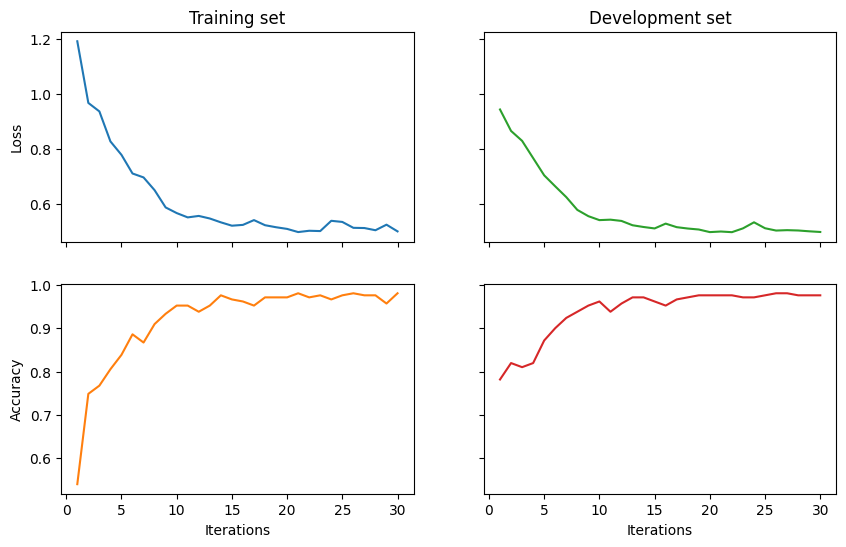

In [37]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer_discocat.epochs + 1)
ax_tl.plot(range_, trainer_discocat.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer_discocat.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer_discocat.val_costs, color=next(colours))
ax_br.plot(range_, trainer_discocat.val_eval_results['acc'], color=next(colours))

test_acc = acc(model_discocat(test_circuits), test_labels)
print('Test accuracy:', test_acc)

# Ансамбль

In [38]:
import torch
from torch.nn.functional import softmax

# Убедитесь, что модель находится в режиме eval
model_bert.eval()

# Передача данных через модель
with torch.no_grad():
    outputs = model_bert(**val_encodings)  # X должен быть токенизированным входом (input_ids, attention_mask, etc.)
    logits = outputs.logits  # Логиты из модели

# Преобразование логитов в вероятности
probs = softmax(logits, dim=1).cpu().numpy()  # Вероятности классов

In [39]:
print(probs)

[[0.98717695 0.00922083 0.00360217]
 [0.00408654 0.06396367 0.9319498 ]
 [0.05572457 0.9233618  0.02091356]
 [0.00343578 0.02140744 0.9751568 ]
 [0.03332556 0.95489484 0.01177956]
 [0.05612822 0.921971   0.02190077]
 [0.9681723  0.02283124 0.00899649]
 [0.9640025  0.02835726 0.00764027]
 [0.04057081 0.94436234 0.01506687]
 [0.02950413 0.9519498  0.0185461 ]
 [0.00484669 0.00860219 0.98655117]
 [0.03620958 0.94180954 0.02198093]
 [0.02387627 0.9576311  0.0184926 ]
 [0.87141067 0.11658286 0.01200649]
 [0.03314756 0.9539477  0.01290479]
 [0.00359184 0.02995663 0.9664515 ]
 [0.00827308 0.9332572  0.05846967]
 [0.40559506 0.58385265 0.01055232]
 [0.00757032 0.02397547 0.9684542 ]
 [0.01782241 0.37294266 0.6092349 ]
 [0.9795324  0.01592396 0.0045436 ]
 [0.03332556 0.95489484 0.01177956]
 [0.02197928 0.9293901  0.04863073]
 [0.5059402  0.47239813 0.02166172]
 [0.00460146 0.01436623 0.9810323 ]
 [0.00310605 0.04655056 0.9503434 ]
 [0.9867748  0.00999503 0.00323018]
 [0.9889177  0.00732544 0.00

In [40]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [41]:
predicted = model_discocat(test_circuits)

In [42]:
print(predicted)

tensor([[9.9244e-01, 7.5599e-03],
        [9.8969e-01, 1.0308e-02],
        [3.3412e-03, 9.9666e-01],
        [9.8671e-01, 1.3291e-02],
        [9.9859e-01, 1.4108e-03],
        [3.7292e-02, 9.6271e-01],
        [9.9995e-01, 4.7820e-05],
        [9.9082e-01, 9.1826e-03],
        [9.9647e-01, 3.5347e-03],
        [9.9565e-01, 4.3481e-03],
        [9.9958e-01, 4.2362e-04],
        [9.9997e-01, 2.7364e-05],
        [9.9834e-01, 1.6598e-03],
        [9.8533e-01, 1.4667e-02],
        [9.2741e-01, 7.2587e-02],
        [6.7749e-03, 9.9323e-01],
        [9.9050e-01, 9.4984e-03],
        [9.9916e-01, 8.3592e-04],
        [1.2039e-03, 9.9880e-01],
        [1.0263e-02, 9.8974e-01],
        [9.8370e-01, 1.6304e-02],
        [5.5590e-02, 9.4441e-01],
        [1.7790e-01, 8.2210e-01],
        [1.0770e-02, 9.8923e-01],
        [9.9995e-01, 4.7305e-05],
        [9.4816e-01, 5.1837e-02],
        [6.7654e-02, 9.3235e-01],
        [9.6463e-01, 3.5372e-02],
        [9.9976e-01, 2.4014e-04],
        [4.114

In [43]:
probs_tensor = torch.tensor(probs)  # Предполагается, что probs уже в формате NumPy или списка
predicted_tensor = torch.tensor(predicted)  # Точно так же для predicted

C:\Users\Vlad_PC_2022\AppData\Local\Temp\ipykernel_14700\3253753170.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_tensor = torch.tensor(predicted)  # Точно так же для predicted


In [44]:
# Приводим к одинаковому количеству примеров (если необходимо)
min_samples = min(probs_tensor.shape[0], predicted_tensor.shape[0])

# Обрезаем тензоры до одинакового числа примеров
probs_tensor = probs_tensor[:min_samples]
predicted_tensor = predicted_tensor[:min_samples]

In [45]:
print("Размер probs_tensor:", probs_tensor.shape)
print("Размер predicted_tensor:", predicted_tensor.shape)

Размер probs_tensor: torch.Size([211, 3])
Размер predicted_tensor: torch.Size([211, 2])


In [46]:
ensemble_inputs = torch.cat((probs_tensor, predicted_tensor), dim=-1)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

# Метки классов
# Добавляем недостающую метку
labels = [0, 1] * (X.shape[0] // 2)  # если X имеет четную длину
if len(labels) < X.shape[0]:
    labels.append(0)  # добавляем недостающую метку

# Преобразование данных для sklearn
X = ensemble_inputs.detach().numpy()
#y = labels 

# Если размерности не совпадают, приводим y к нужной размерности
if X.shape[0] != y.shape[0]:
    if len(y) < len(X):
        # Если y меньше, чем X, дублируем значения
        y = np.tile(y, (len(X) // len(y)) + 1)[:len(X)]
    elif len(y) > len(X):
        # Если y больше, чем X, обрезаем до нужного размера
        y = y[:len(X)]

# Обучение мета-модели с использованием градиентного бустинга
meta_model = GradientBoostingClassifier()
meta_model.fit(X, y)

# Прогноз
ensemble_prediction = meta_model.predict(X)
print("Прогноз ансамбля:", ensemble_prediction)

Прогноз ансамбля: [2 0 2 1 0 2 2 0 2 0 2 1 2 0 2 0 2 2 0 0 2 2 0 2 0 2 0 2 1 0 2 1 2 2 0 2 2
 0 2 2 2 2 1 0 1 2 1 2 0 0 2 2 2 0 2 2 0 2 0 2 2 1 2 0 2 2 2 2 0 2 0 2 0 2
 0 0 2 0 2 2 2 0 0 2 0 2 0 2 2 2 0 0 2 1 2 0 2 1 2 0 2 0 2 0 2 0 0 2 2 2 0
 0 2 2 0 0 2 0 0 2 0 2 2 2 2 2 2 2 0 2 2 1 2 2 0 2 2 2 0 2 2 0 2 0 2 0 1 0
 2 0 2 1 2 0 2 2 0 1 2 2 0 2 0 0 2 0 0 1 0 2 1 0 2 2 0 2 2 0 2 0 2 0 0 1 0
 2 0 0 1 1 1 0 0 2 2 2 0 1 0 2 2 1 2 1 1 0 2 0 2 2 2]


In [48]:
from sklearn.metrics import accuracy_score

# Прогнозы ансамбля
ensemble_prediction = meta_model.predict(X)

# Рассчитываем точность (accuracy)
accuracy_ensemble = accuracy_score(y, ensemble_prediction)

# Выводим значение точности
print("Accuracy ансамбля:", accuracy_ensemble)

Accuracy ансамбля: 0.990521327014218
